In [31]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten, Add, Conv1D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from transformers import AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.nn import softmax as tf_softmax
import nltk
from nltk.stem import WordNetLemmatizer 
%matplotlib inline

In [32]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive: ', is_interactive())

Interactive:  True


In [33]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [34]:
task = 'b' # a,b,c
keys_for_task = {'a':'label_sexist','b':'label_category','c':'label_vector'}
key_for_task = keys_for_task[task]

# **DATA PREPROCESSING**

In [35]:
df = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism-edos/starting_kit/train_all_tasks.csv',delimiter=',',encoding='utf-8')
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [36]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize(sentence):
    return ' '.join([lemmatizer.lemmatize(word) for word in sentence.split(' ')])

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [37]:
df['text'] = df['text'].map(lambda sentence:lemmatize(sentence))
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing wa pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some woman,not sexist,none,none


In [38]:
df.drop(['rewire_id'],axis=1,inplace=True)
df.head()

,text,label_sexist,label_category,label_vector
0,"Damn, this writing wa pretty chaotic",not sexist,none,none
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,Understand. Know you're right. At same time I ...,not sexist,none,none
4,Surprized they didn't stop and rape some woman,not sexist,none,none


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            14000 non-null  object
 1   label_sexist    14000 non-null  object
 2   label_category  14000 non-null  object
 3   label_vector    14000 non-null  object
dtypes: object(4)
memory usage: 437.6+ KB
None


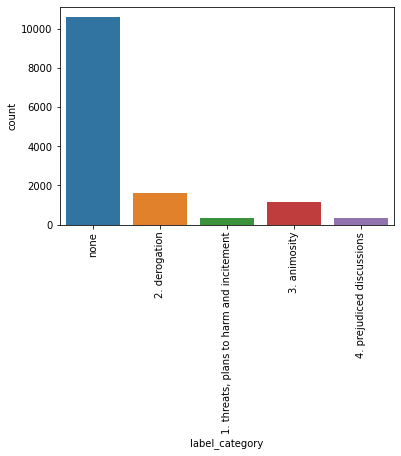

In [39]:
def count_plot(df, name, key_count = key_for_task):
    print(df.info())
    sn.countplot(data=df, x=key_count)
    plt.xticks(rotation = 90)
    plt.savefig(name)
    plt.show()
    
count_plot(df,"distribution.svg")

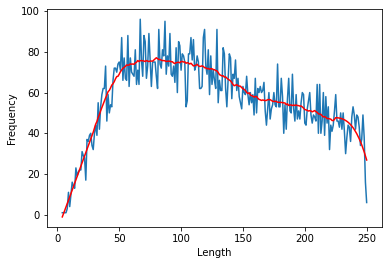

In [40]:
lens = df.text.str.len().value_counts()
count_plot = pd.DataFrame({'leng':lens.index, 'freq':lens.values}).sort_values('leng')
plt.plot(count_plot.leng,count_plot.freq)
plt.plot(count_plot.leng,savgol_filter(count_plot.freq, 51, 3), color='red')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# **LABEL ENCODING**

In [41]:
label_encoder = LabelEncoder()

# label encoding

X = df['text']
Y = df[key_for_task]
Y = label_encoder.fit_transform(Y)

In [42]:
label_encoder_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_encoder_mapping)
inverse_label_encoder_mapping = {label_encoder_mapping[k]:k for k in label_encoder_mapping}
print(inverse_label_encoder_mapping)

NUM_CLASS = len(label_encoder_mapping)

{'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3, 'none': 4}
{0: '1. threats, plans to harm and incitement', 1: '2. derogation', 2: '3. animosity', 3: '4. prejudiced discussions', 4: 'none'}


In [43]:
# one hot encoding

Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASS)

In [44]:
DEBUG_EPOCH = 20 

EPOCH = DEBUG_EPOCH if is_interactive() else 180
print(EPOCH)

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

20


# **SENTENCE TRANSFORMATION**

In [45]:
# "sentence-transformers/all-MiniLM-L6-v2"
## https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

class Sentence2Sentence(Layer):
    def __init__(self, **kwargs):
        super(Sentence2Sentence, self).__init__(**kwargs)

        pre_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])

    def process(self,i,t,a):

        def __call(i, t, a):
            model_output = self.model({'input_ids': i.numpy(),'token_type_ids': t.numpy(),'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, token_type_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        token_type_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, token_type_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 384)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        # Reshape embeddings to have a third dimension
        embeddings = tf.expand_dims(embeddings, axis=-1)
        return embeddings

In [46]:
class StringLowerLayer(Layer):
    def __init__(self, **kwargs):
        super(StringLowerLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        return tf.strings.lower(inputs)

In [47]:
class StressLayer(Layer):
    def __init__(self, **kwargs):
        super(StressLayer, self).__init__(**kwargs)

# **MODEL ARCHITECTURE**

In [48]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def get_model():
    # Input layer
    input_layer = Input(shape=(1,), dtype=tf.string,)
    sentence_layer = Sentence2Sentence()(input_layer)
    
    # Convolutional layers
    conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(sentence_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    conv3 = Conv1D(filters=32, kernel_size=2, activation='relu')(pool2)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    # Flatten layer
    flatten_layer = Flatten()(pool3)

    # Dense layers
    dense1 = Dense(128, activation='relu')(flatten_layer)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output_layer = Dense(NUM_CLASS, activation='softmax')(dropout2)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy',
            F1Score(num_classes=NUM_CLASS,average='weighted'),
        ],
    )
    
    return model

In [49]:
model = get_model()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.8M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sentence2_sentence_1 (Senten (None, 384, 1)            22713216  
_________________________________________________________________
conv1d (Conv1D)              (None, 380, 128)          768       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 190, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 188, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 94, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 93, 32)            4128  

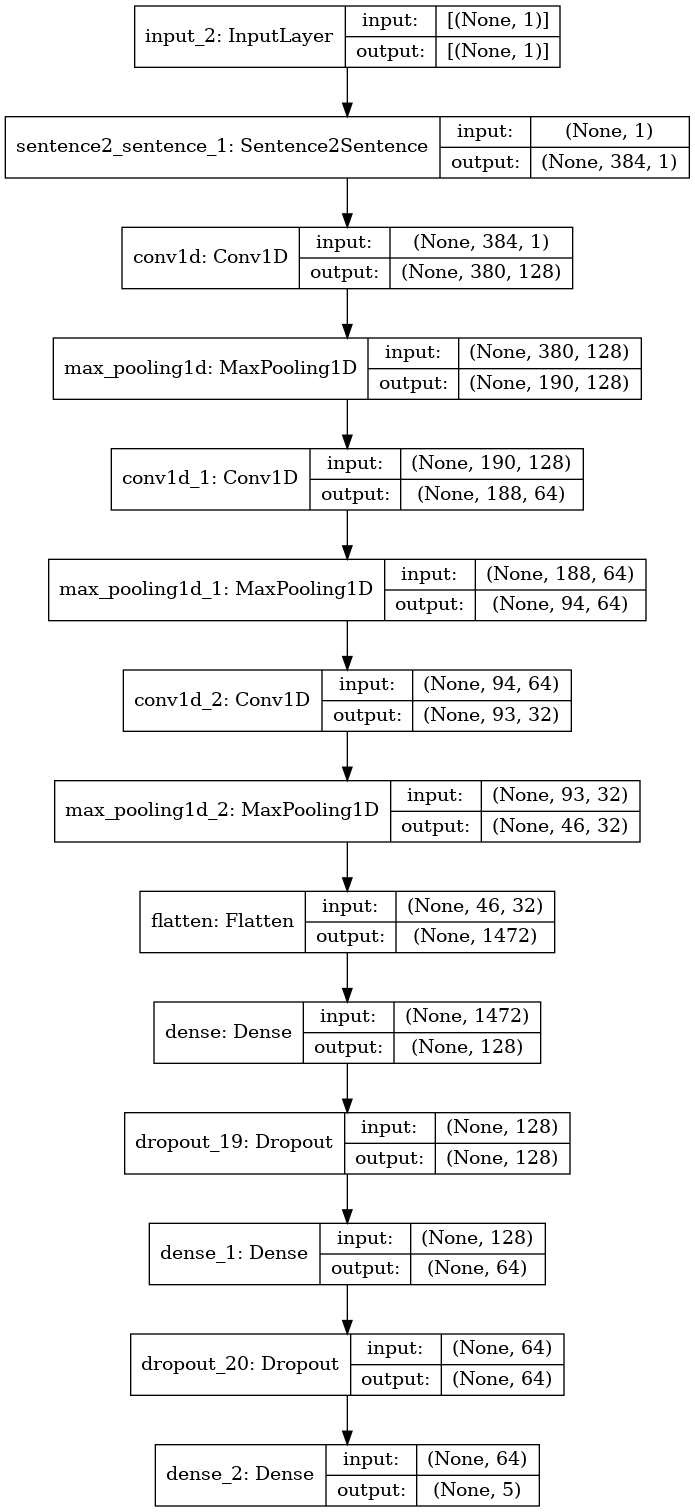

In [51]:
tf.keras.utils.plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True,dpi=None,)

# **SPLIT AND REGULARIZATION**

In [52]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10)
early_stopping_callback = EarlyStopping(monitor='val_loss',min_delta=0,patience=30,verbose=0, mode='auto')
model_saver = ModelCheckpoint(filepath='model.h5', save_best_only=True)

callbacks = [early_stopping_callback, lr_reducer,model_saver]

In [53]:
SHUFFLE_DS = 1024
BATCH_SIZE_DS = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

if task == 'a':
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3, stratify=Y)
else:
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3)


# train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).repeat().shuffle(SHUFFLE_DS).batch(BATCH_SIZE_DS).prefetch(AUTO)
# val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_Y)).repeat().shuffle(SHUFFLE_DS).batch(BATCH_SIZE_DS).prefetch(AUTO)
    
N_STEPS = len(train_X) / BATCH_SIZE_DS

# **MODEL INFERENCE**

In [54]:
history_model = model.fit(train_X, train_Y,epochs=EPOCH,validation_data=(val_X, val_Y), callbacks=callbacks, steps_per_epoch = N_STEPS)

Epoch 1/20
612/612 [==============================] - 61s 89ms/step - loss: 0.4005 - accuracy: 0.6970 - f1_score: 0.6341 - val_loss: 0.2874 - val_accuracy: 0.7590 - val_f1_score: 0.6551
Epoch 2/20
612/612 [==============================] - 53s 87ms/step - loss: 0.3351 - accuracy: 0.7451 - f1_score: 0.6485 - val_loss: 0.2860 - val_accuracy: 0.7590 - val_f1_score: 0.6551
Epoch 3/20
612/612 [==============================] - 53s 87ms/step - loss: 0.3257 - accuracy: 0.7511 - f1_score: 0.6512 - val_loss: 0.2829 - val_accuracy: 0.7590 - val_f1_score: 0.6551
Epoch 4/20
612/612 [==============================] - 54s 88ms/step - loss: 0.3176 - accuracy: 0.7550 - f1_score: 0.6513 - val_loss: 0.2809 - val_accuracy: 0.7590 - val_f1_score: 0.6551
Epoch 5/20
612/612 [==============================] - 52s 85ms/step - loss: 0.3124 - accuracy: 0.7555 - f1_score: 0.6513 - val_loss: 0.2813 - val_accuracy: 0.7590 - val_f1_score: 0.6551
Epoch 6/20
612/612 [==============================] - 53s 87ms/step - 

In [59]:
!mkdir history

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘history’: File exists


In [60]:
with open('history/history.json','w') as f:
    f.write(str(history_model.history))

In [61]:
!mkdir figures

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘figures’: File exists


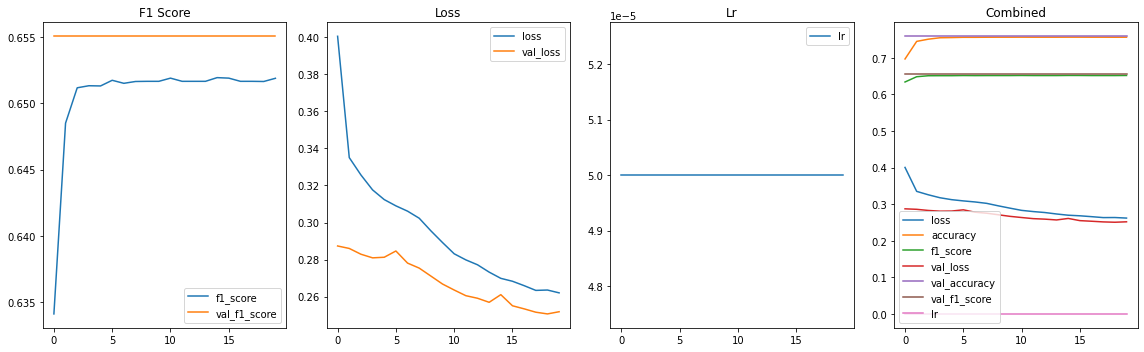

In [62]:
def captilize(string):
    string = string.replace("_"," ")
    return string.title()
    
    
def plot_graphs(data, keys):
    fig, axes = plt.subplots(1, (len(keys) + 1) , figsize=(16, 5))
    plt.legend(loc='best')
    
    for i in range(len(keys)):
        df_graph = pd.DataFrame({x:data[x] for x in data if keys[i] in x})
        df_keys = [x for x in data if keys[i] in x]
        df_graph[df_keys].plot(ax=axes[i])
        axes[i].set_title(captilize(keys[i]))
        
    last_index = len(keys)
    all_keys = [x for x in data if x]
    
    df_combined = pd.DataFrame({x: data[x] for x in data})
    df_combined[all_keys].plot(ax=axes[last_index])
    axes[len(keys)].set_title('Combined')
    
    plt.tight_layout()
    
    plt.savefig('figures/figure_optimizer.svg')
    plt.show()
        
plot_graphs(data = history_model.history, keys= ['f1_score','loss', 'lr'])